In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial D1: FIMO

The name `tangermeme` is a play on `MEME` and the `MEME suite`, which are one of the original collection of tools for biological sequence analyses. These tools included `MEME`, which would discover repeating patterns in collections of short sequences, `FIMO` which would scan a PWM over sequences and find statistically significant matches, `TOMTOM` which would compare a PWM to a collection of PWMs, and many other tools that have been developed over decades.

Although the scope of `tangermeme` is larger than that of the MEME suite -- in that `tangermeme` implements operations and analysis tools for machine learning models -- many of the MEME suite tools are implemented in PyTorch because they are used in downstream `tangermeme` methods. Because these implementations are in PyTorch they are generally much faster than the original implementations because they can make use of GPU acceleration, the latest computational advances, and other things such as mixed precision if desired. As those tools get added to tangermeme, short snippets demonstrating their usage will be added to this tutorial.

#### FIMO

Finding Individual Motif Occurances ([FIMO](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3065696/)) is a tool for scanning PWMs across sequences and returning statistically significant occurances. There are basically two steps to the procedure: calculating a score that is just the convolution of the given PWMs and the one-hot encoded sequence, and converting that score to a valid p-value. The first step is trivial to implement. The second step involves using a dynamic programming algorithm that accounts for the length of the sequence and the information content at each position. 

This algorithm is implemented in `tangermeme.tools.fimo`. 

Let's begin by loading up some PWMs from a MEME-formatted file.

In [2]:
from tangermeme.io import read_meme

pwms = read_meme("../../tests/data/test.meme")
pwms.keys()

dict_keys(['MEOX1_homeodomain_1', 'HIC2_MA0738.1', 'GCR_HUMAN.H11MO.0.A', 'FOSL2+JUND_MA1145.1', 'TEAD3_TEA_2', 'ZN263_HUMAN.H11MO.0.A', 'PAX7_PAX_2', 'SMAD3_MA0795.1', 'MEF2D_HUMAN.H11MO.0.A', 'FOXQ1_MOUSE.H11MO.0.C', 'TBX19_MA0804.1', 'Hes1_MA1099.1'])

In [3]:
pwms['HIC2_MA0738.1']

array([[0.46108, 0.06971, 0.40428, 0.06493],
       [0.     , 0.02336, 0.     , 0.97664],
       [0.08387, 0.0601 , 0.83039, 0.02564],
       [0.00467, 0.99249, 0.00284, 0.     ],
       [0.08078, 0.90826, 0.     , 0.01096],
       [0.29973, 0.70027, 0.     , 0.     ],
       [0.50961, 0.14513, 0.2637 , 0.08156],
       [0.15743, 0.44981, 0.25291, 0.13985],
       [0.15539, 0.35412, 0.20466, 0.28583]])

Next, let's create the FIMO object and pass these motifs in.

In [4]:
from tangermeme.tools.fimo import FIMO

model = FIMO(pwms)

When the model is created, it runs the dynamic programming algorithm pre-calculating a mapping of scores to p-values for each motif. This was recently converted to a numba-accelerated set of functions so should be pretty fast, but may take a few seconds if using thousands of motifs, i.e., because you're running all JASPAR motifs against sequence.

Next, let's load up some sequences to run FIMO on.

In [5]:
from tangermeme.io import extract_loci

X = extract_loci("../../tests/data/test.bed", "../../tests/data/test.fa", in_window=40).float()
X.shape

torch.Size([5, 4, 40])

The most basic thing we can do is calculate the scores -- which are just the convolution scan of the PWMs against the one-hot encoded sequence. This can still be done efficiently when motifs are of differing lengths because the shorter motifs are padded with zeroes.

In [6]:
y = model(X)
y.shape

torch.Size([5, 12, 2, 21])

The shape of the return is `(batch_size, n_motifs, n_strands, n_positions)`. Note that `n_positions` is not necessarily equal to the original length of the sequence because the motif is only run against entire spans of sequence. So, `n_positions` will actually be the original length of the sequence minus the length of the longest motif.

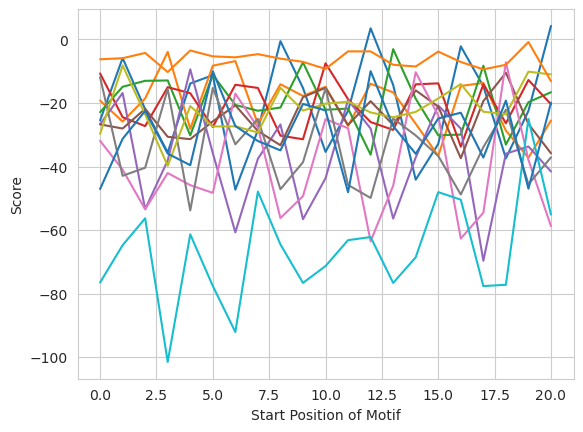

In [7]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.plot(y[0, :, 0].numpy(force=True).T)
plt.xlabel("Start Position of Motif")
plt.ylabel("Score")
plt.show()

Converting all of these scores to p-values can be time-consuming, so the score to p-value mapping is calculated internally just to determine the score threshold for a given p-value threshold. This way, you don't need to spend a lot of time computing p-values for scores that are known to not be relevant. Finding all such p-value hits can be done using the `hits` method.

In [8]:
hits = model.hits(X, threshold=0.01)

/users/jmschr/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
30it [00:00, 19639.32it/s]


By default, the return from `hits` is a list of pandas DataFrames, where each DataFrame is bed-formatted and contains all hits for a single motif. So, if you loaded 23 motifs into the FIMO object initially, there will be 23 DataFrames returned. 

In [9]:
len(hits)

12

In [10]:
hits[0]

,example_idx,start,end,strand,score,p-value,seq
0,0,12,22,+,3.512175,0.004463,ACTAACTGAC
1,0,20,30,+,4.261113,0.003427,ACTGATGATG
2,0,20,30,-,1.616617,0.008347,ACTGATGATG
3,0,23,33,-,3.592150,0.004342,GATGATGATG
4,1,16,26,-,3.232642,0.004923,TACCATGACT


However, sometimes you are interested in all of the hits on a locus-specific axis rather than a motif-specific axis. For instance, if you have a single locus that you want to annotate, you are interested in all of the motif hits anywhere on that sequence and it can be a pain to have to aggregate that across many DataFrame objects.

If you are interested in the locus-specific axis you can pass `dim=1` in.

In [11]:
hits = model.hits(X, threshold=0.01, dim=1)
hits[0]

30it [00:00, 15109.16it/s]


,motif,start,end,strand,score,p-value,seq
0,MEOX1_homeodomain_1,12,22,+,3.512175,0.004463,ACTAACTGAC
1,MEOX1_homeodomain_1,20,30,+,4.261113,0.003427,ACTGATGATG
2,MEOX1_homeodomain_1,20,30,-,1.616617,0.008347,ACTGATGATG
3,MEOX1_homeodomain_1,23,33,-,3.592150,0.004342,GATGATGATG
4,FOSL2+JUND_MA1145.1,24,39,-,-0.538747,0.008368,ATGATGATGCATGCT
5,TEAD3_TEA_2,30,38,-,-5.082814,0.008408,ATGCATGC
6,PAX7_PAX_2,14,24,+,-10.314709,0.009835,TAACTGACTG
7,PAX7_PAX_2,18,28,+,-7.193218,0.005223,TGACTGATGA
8,PAX7_PAX_2,14,24,-,-10.090963,0.009407,TAACTGACTG
9,PAX7_PAX_2,18,28,-,-5.894826,0.003964,TGACTGATGA


Looking at the first DataFrame will tell us what motifs occur and where on the first sequence.

Finally, if you want an aggregated matrix of motif hits where each row is a different locus, each column is a motif, and the value is the maximum score of each motif at each locus, we can use the `hit_matrix` method.

In [12]:
y_hits = model.hit_matrix(X)
y_hits.shape

torch.Size([5, 12])

In [13]:
y_hits

tensor([[  4.2611,  -3.9193,  -3.0517,  -0.5387,  -5.0828,  -8.0606,  -5.8948,
         -11.8521,  -8.1839, -25.0211,  -9.2288,   3.4261],
        [  3.2326,   0.3824,  -7.8207,  -5.1872,  -5.2034,   0.3497, -18.1375,
          -3.5999,  -1.3253, -26.7751,  -8.9245,   1.4679],
        [ -0.7967,   4.1468,   5.0787,  -2.0847, -17.2555,  -8.1860, -16.7593,
          -3.4265,  -0.9905, -17.7709, -15.4074,   3.0202],
        [ -4.3711,  -2.1672,  -6.6681,  -7.6389, -11.3639,  -1.6247, -14.1465,
          -7.1743,   1.7523, -22.9861, -14.0714,   1.2057],
        [ -4.3711,  -0.2420,  -3.2560,  -7.6389,  -5.8535,   1.1055, -14.1465,
          -7.1743,   1.7523, -23.4009, -10.1734,   0.5615]])

### Comparison with command-line tool

In [14]:
import os
import pandas

os.system("fimo --text --no-qvalue --bfile --uniform-- ../../tests/data/test.meme ../../tests/data/test.fa > test.fimo")

df = pandas.read_csv("test.fimo", sep="\t")
df.head(n=20)

Using motif +MEOX1_homeodomain_1 of width 10.
Using motif -MEOX1_homeodomain_1 of width 10.
         Converting Z to N.
Using motif +HIC2_MA0738.1 of width 9.
Using motif -HIC2_MA0738.1 of width 9.
         Converting Z to N.
Using motif +GCR_HUMAN.H11MO.0.A of width 15.
Using motif -GCR_HUMAN.H11MO.0.A of width 15.
         Converting Z to N.
Using motif +FOSL2+JUND_MA1145.1 of width 15.
Using motif -FOSL2+JUND_MA1145.1 of width 15.
         Converting Z to N.
Using motif +TEAD3_TEA_2 of width 8.
Using motif -TEAD3_TEA_2 of width 8.
         Converting Z to N.
Using motif +ZN263_HUMAN.H11MO.0.A of width 20.
Using motif -ZN263_HUMAN.H11MO.0.A of width 20.
         Converting Z to N.
Using motif +PAX7_PAX_2 of width 10.
Using motif -PAX7_PAX_2 of width 10.
         Converting Z to N.
Using motif +SMAD3_MA0795.1 of width 10.
Using motif -SMAD3_MA0795.1 of width 10.
         Converting Z to N.
Using motif +MEF2D_HUMAN.H11MO.0.A of width 12.
Using motif -MEF2D_HUMAN.H11MO.0.A of width 12.


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MEOX1_homeodomain_1,NaN,chr7,1351,1360,+,11.4342,0.000072,NaN,ACTCATTACC
1,GCR_HUMAN.H11MO.0.A,NaN,chr1,70,84,+,10.9091,0.000068,NaN,ATGACTGACTGTACT
2,FOSL2+JUND_MA1145.1,NaN,chr5,39,53,-,10.1440,0.000095,NaN,GAGTTGCGTCATCAG
3,FOSL2+JUND_MA1145.1,NaN,chr7,396,410,+,10.7920,0.000065,NaN,TCATTACTTCACTGA
4,SMAD3_MA0795.1,NaN,chr5,104,113,+,10.4474,0.000046,NaN,tatctagaCA
5,SMAD3_MA0795.1,NaN,chr5,104,113,-,10.4474,0.000046,NaN,TGTCTAGATA
6,MEF2D_HUMAN.H11MO.0.A,NaN,chr7,1037,1048,+,11.0779,0.000056,NaN,TGCTATATATAT
7,FOXQ1_MOUSE.H11MO.0.C,NaN,chr5,122,133,+,3.5000,0.000095,NaN,AGTTGTATATAT


In [15]:
import torch
import pyfaidx

from tangermeme.utils import one_hot_encode
from tangermeme.predict import predict

fasta = pyfaidx.Fasta("../../tests/data/test.fa")
seqs = [fasta[i][:].seq.upper() for i in range(len(fasta.keys()))]
max_len = max([len(seq) for seq in seqs])
seqs = [seq + 'N'*(max_len - len(seq)) for seq in seqs]

ignore = 'NZ'
X = torch.stack([one_hot_encode(seq, ignore=ignore) for seq in seqs]).type(torch.float64)
fimo = FIMO("../../tests/data/test.meme", bin_size=0.25, eps=0.0001)

y = predict(fimo, X)
y.shape

motifs = read_meme("../../tests/data/test.meme")
motif_names = list(motifs.keys())
seq_names = list(fasta.keys())


hits = FIMO(motifs, bin_size=0.01, eps=0.0001).hits(X, dim=0)

for i, df in enumerate(hits):
    df['motif_id'] = [motif_names[i] for _ in range(df.shape[0])]
    df['sequence_name'] = [seq_names[i] for i in df['example_idx']]
    df['stop'] = df['end']
    df['motif_alt_id'] = ['' for _ in range(df.shape[0])]
    df['q-value'] = ['' for _ in range(df.shape[0])]
    df['matched_sequence'] = df['seq']
    del df['example_idx'], df['end'], df['seq']

hits = pandas.concat(hits)
hits = hits[['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 
    'strand', 'score', 'p-value', 'q-value', 'matched_sequence']]

13it [00:00, 10469.65it/s]
/tmp/ipykernel_3680183/2984672063.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)


In [16]:
df = pandas.read_csv("test.fimo", sep="\t")
df.head(n=20)

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MEOX1_homeodomain_1,NaN,chr7,1351,1360,+,11.4342,0.000072,NaN,ACTCATTACC
1,GCR_HUMAN.H11MO.0.A,NaN,chr1,70,84,+,10.9091,0.000068,NaN,ATGACTGACTGTACT
2,FOSL2+JUND_MA1145.1,NaN,chr5,39,53,-,10.1440,0.000095,NaN,GAGTTGCGTCATCAG
3,FOSL2+JUND_MA1145.1,NaN,chr7,396,410,+,10.7920,0.000065,NaN,TCATTACTTCACTGA
4,SMAD3_MA0795.1,NaN,chr5,104,113,+,10.4474,0.000046,NaN,tatctagaCA
5,SMAD3_MA0795.1,NaN,chr5,104,113,-,10.4474,0.000046,NaN,TGTCTAGATA
6,MEF2D_HUMAN.H11MO.0.A,NaN,chr7,1037,1048,+,11.0779,0.000056,NaN,TGCTATATATAT
7,FOXQ1_MOUSE.H11MO.0.C,NaN,chr5,122,133,+,3.5000,0.000095,NaN,AGTTGTATATAT


In [17]:
hits

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MEOX1_homeodomain_1,,chr7,1350,1360,+,11.446572,0.000072,,ACTCATTACC
0,GCR_HUMAN.H11MO.0.A,,chr1,69,84,+,10.891225,0.000067,,ATGACTGACTGTACT
0,FOSL2+JUND_MA1145.1,,chr5,38,53,-,10.156786,0.000096,,CTGATGACGCAACTC
1,FOSL2+JUND_MA1145.1,,chr7,395,410,+,10.791449,0.000066,,TCATTACTTCACTGA
0,SMAD3_MA0795.1,,chr5,103,113,+,10.445715,0.000046,,TATCTAGACA
1,SMAD3_MA0795.1,,chr5,103,113,-,10.446602,0.000046,,TATCTAGACA
0,MEF2D_HUMAN.H11MO.0.A,,chr7,1036,1048,+,11.063244,0.000056,,TGCTATATATAT
0,FOXQ1_MOUSE.H11MO.0.C,,chr1,281,293,+,3.391391,0.000082,,CATAAAAAAAAA
1,FOXQ1_MOUSE.H11MO.0.C,,chr4,237,249,+,3.391391,0.000082,,TATAAAAAAAAA
2,FOXQ1_MOUSE.H11MO.0.C,,chr4,236,248,-,4.655060,0.000050,,ATATAAAAAAAA
